# Our first Neural Network
Train a generic MLP as binary classifier of protein-coding/non-coding RNA.

In [54]:
import numpy as np
import pandas as pd

## K-mer frequency, K=2

In [55]:
nc2 = pd.read_csv ('ncRNA.2mer.features.csv')
pc2 = pd.read_csv ('pcRNA.2mer.features.csv')
nc2['class']=0
pc2['class']=1
rna2mer=pd.concat((nc2,pc2),axis=0)
rna2mer

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,class
0,1,535,39,21,38,30,31,48,11,44,31,30,26,28,27,36,40,54,0
1,2,590,37,21,47,27,43,55,9,51,35,42,55,26,18,40,46,37,0
2,3,629,61,30,53,41,48,41,5,45,48,30,31,32,28,38,51,46,0
3,4,1319,109,68,127,77,110,75,16,82,106,79,100,58,57,61,100,93,0
4,5,323,16,21,26,12,28,23,4,21,24,23,31,19,7,9,37,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20147,20148,297,17,24,13,29,22,28,6,36,5,18,6,7,39,22,11,13,1
20148,20149,1378,118,152,47,99,142,147,31,153,36,55,25,21,119,119,34,79,1
20149,20150,1812,170,166,82,132,190,212,40,180,48,81,30,33,142,163,40,102,1
20150,20151,525,18,5,34,46,5,4,8,20,34,13,80,59,45,15,65,73,1


In [56]:
# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
bin_labels= sizebin(rna2mer)
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
# split(x,y) expects that y is the labels. 
# Trick: Instead of y, give it it the bin labels that we generated.
for train_index,test_index in splitter.split(rna2mer,bin_labels):
    train_set = rna2mer.iloc[train_index]
    test_set = rna2mer.iloc[test_index]
train_set

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,class
1280,1281,348,27,16,30,25,26,19,3,16,27,11,25,21,18,18,26,39,0
9088,9089,534,60,24,44,25,43,41,8,40,29,36,47,24,22,30,37,23,0
6069,6070,592,44,34,63,25,50,39,19,27,55,32,65,32,16,30,38,22,1
18549,18550,945,72,46,70,48,52,43,65,38,85,61,83,66,28,48,76,63,1
15027,15028,4382,177,222,310,108,298,515,368,278,270,483,467,177,73,239,251,145,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,3387,578,74,24,35,59,35,15,3,22,31,18,20,41,52,18,53,77,0
6495,6496,562,44,23,52,33,44,36,4,39,44,30,40,24,19,34,42,53,0
6409,6410,740,52,32,80,31,50,43,23,48,61,49,99,32,32,40,39,28,1
7640,7641,3156,206,187,230,165,259,280,78,230,223,182,230,144,100,198,241,202,1


In [57]:
# The seqnum and seqlen were normalized also. We don't need them any more.
y_train_all=  train_set[['class']].copy()
X_train_all=  train_set.div(train_set['seqlen'],axis=0)
X_train_all=  X_train_all.drop(columns=['class','seqnum','seqlen'])

y_test=   test_set[['class']].copy()
X_test=   test_set.div(test_set['seqlen'],axis=0)
X_test=   X_test.drop(columns=['class','seqnum','seqlen'])

X_train,y_train=X_train_all[:25000],y_train_all[:25000]
X_valid,y_valid=X_train_all[25000:],y_train_all[25000:]

y_train

,class
1280,0
9088,0
6069,1
18549,1
15027,1
...,...
3389,0
10178,1
11158,0
5030,1


In [58]:
y_valid

,class
3292,0
7363,1
5979,0
2219,1
16124,1
...,...
3386,0
6495,0
6409,1
7640,1


In [59]:
# Just check that one value (top left) comes out as expected.
kmer_count=train_set.iloc[0].loc['AA']
seqlen=train_set.iloc[0].loc['seqlen']
expected_value=kmer_count/seqlen
X_train.iloc[0].loc['AA'] == expected_value

True

In [66]:
# Geron Chapter 10
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
                            
# We tried all these. No difference.
act="relu" 
act="tanh"
act="sigmoid"
dim=16

# Adding non-trained Layer Normalization improved accuracy a tiny bit sometimes.

mlp2 = keras.models.Sequential([
    keras.layers.LayerNormalization(trainable=False),
    keras.layers.Dense(1,  activation=act,dtype='float32')
])
# Error:
# ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))
# This didn't help:
#y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
#y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [69]:
# See page 302 for explanation of these parameters.
# See also the keras docs e.g. 
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy
# Note keras can take parameters for % train vs % validation.

# It seems the BinaryCrossentropy assumes labels are probabilities.
# Instead of loss="binary_crossentropy",
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
mlp2.compile(loss=bc, optimizer="sgd",metrics=["accuracy"])

# Tested up to 30 epochs with no gain
history = mlp2.fit(X_train,y_train,epochs=7,validation_data=(X_valid,y_valid))

Epoch 1/7
782/782 [==============================] - 2s 2ms/step - loss: 0.6059 - accuracy: 0.6692 - val_loss: 0.6026 - val_accuracy: 0.6671
Epoch 2/7
782/782 [==============================] - 2s 2ms/step - loss: 0.6035 - accuracy: 0.6721 - val_loss: 0.6007 - val_accuracy: 0.6716
Epoch 3/7
782/782 [==============================] - 2s 2ms/step - loss: 0.6017 - accuracy: 0.6736 - val_loss: 0.5992 - val_accuracy: 0.6707
Epoch 4/7
782/782 [==============================] - 2s 2ms/step - loss: 0.6001 - accuracy: 0.6740 - val_loss: 0.5982 - val_accuracy: 0.6743
Epoch 5/7
782/782 [==============================] - 2s 2ms/step - loss: 0.5989 - accuracy: 0.6762 - val_loss: 0.5969 - val_accuracy: 0.6711
Epoch 6/7
782/782 [==============================] - 1s 2ms/step - loss: 0.5978 - accuracy: 0.6766 - val_loss: 0.5962 - val_accuracy: 0.6788
Epoch 7/7
782/782 [==============================] - 2s 2ms/step - loss: 0.5970 - accuracy: 0.6789 - val_loss: 0.5955 - val_accuracy: 0.6796


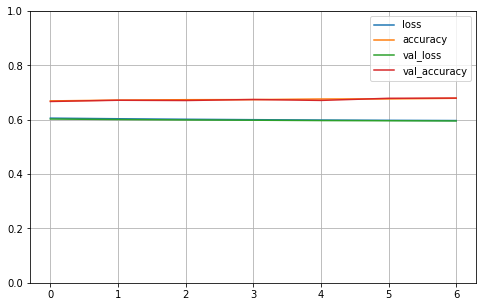

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## K-mer frequency, K=3

In [ ]:
nc3 = pd.read_csv ('ncRNA.3mer.features.csv')
pc3 = pd.read_csv ('pcRNA.3mer.features.csv')
nc3['class']=0
pc3['class']=1
rna3mer=pd.concat((nc3,pc3),axis=0)
bin_labels= sizebin(rna3mer)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(rna3mer,bin_labels):
    train_set = rna3mer.iloc[train_index]
    test_set =  rna3mer.iloc[test_index]
train_norm=train_set.div(train_set['seqlen'],axis=0)
test_norm=  test_set.div( test_set['seqlen'],axis=0)
train_set=None
test_set=None
y_train_all=  train_norm[['class']].copy()
y_test=        test_norm[['class']].copy()
X_train_all=  train_norm.drop(columns=['class','seqnum','seqlen'])
X_test=        test_norm.drop(columns=['class','seqnum','seqlen'])
train_norm=None
X_train,y_train=X_train_all[:25000],y_train_all[:25000]
X_valid,y_valid=X_train_all[25000:],y_train_all[25000:]
y_train_all=None
X_train_all=None
act="sigmoid"
dim=8  # values up to 256 did not help
mlp3 = keras.models.Sequential([
    keras.layers.LayerNormalization(trainable=False),
    keras.layers.Dense(dim,activation=act,dtype='float32'),
    keras.layers.Dense(dim,activation=act,dtype='float32'),
    keras.layers.Dense(dim,activation=act,dtype='float32'),
    keras.layers.Dense(2,activation="sigmoid",dtype='float32')
])
mlp3.compile(loss="binary_crossentropy",optimizer="sgd",metrics=["accuracy"])
history = mlp3.fit(X_train,y_train,epochs=7,validation_data=(X_valid,y_valid))

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()